# 1. Introduction

 Importing necessary modules

In [1]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import classification_report

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import train and test data
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
gender_submission=pd.read_csv('data/gender_submission.csv')
# View the train data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# View the test data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# View the example submisison dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data description

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# # Let's find missing values in the data

<AxesSubplot:>

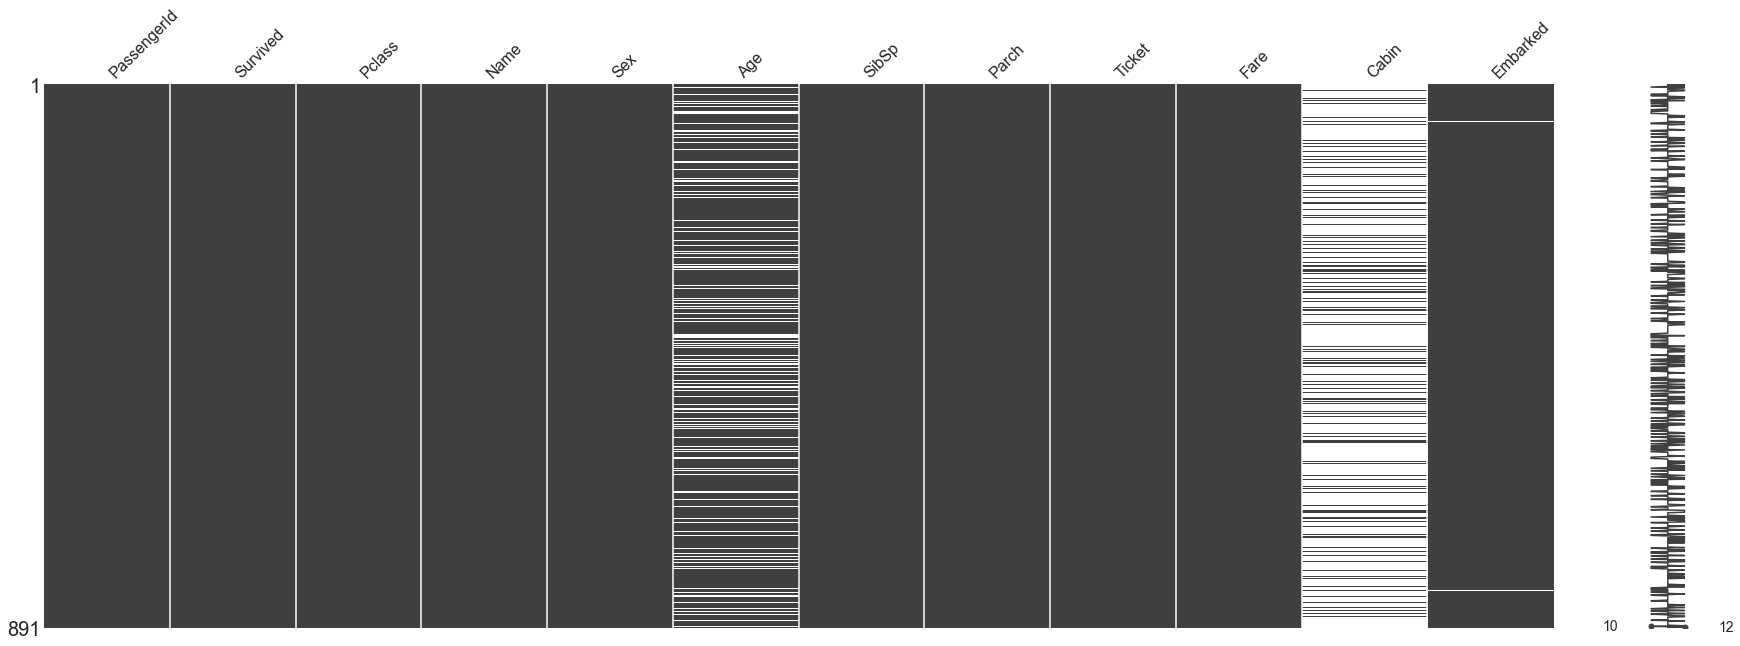

In [6]:
missingno.matrix(train,figsize=(30,10))

By looking at the matrix above, we can conclude that Age and Cabin both have missing values.
The number of missing values is extremely high

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform our data analysis, let's create two new dataframes

We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.

In [8]:
df_bin = pd.DataFrame()
df_con = pd.DataFrame()

## lets get the data types

In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually
We'll go through each column iteratively and see which ones to use in our first models.
Some may need more preprocessing than others to get ready.

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Target feature: Survived
Description: Whether the passenger survived or not.
    
Key: 0 = did not survive, 1 = survived
    
This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


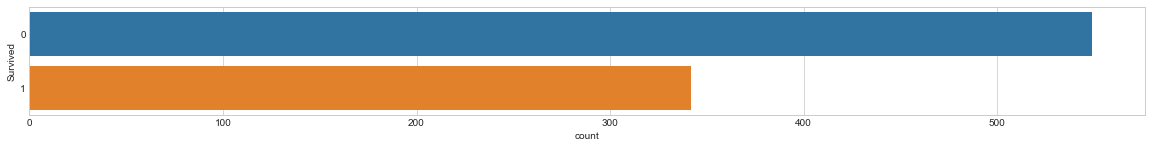

In [11]:
#How many people survived
fig = plt.figure(figsize=(20,2))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [12]:
#let's add in our dataframe
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [13]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [14]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Feature: Pclass
Description: The ticket class of the passenger
Key: 1 = 1st, 2 = 2nd, 3 = 3rd

#### Let's plot the distribution
We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

<AxesSubplot:xlabel='Pclass', ylabel='Density'>

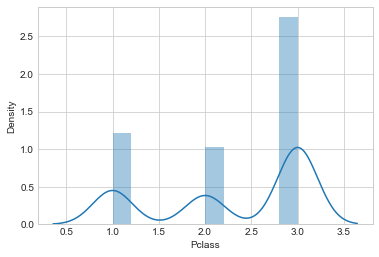

In [15]:
sns.distplot(train.Pclass)

We can see that the number are numerical but they are categories

### Let's check for any missing values

In [16]:
train.Pclass.isnull().sum()

0

Since,there are no missing values in Pclass
we will add them to our dataframe

In [17]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

### Feature: Name
Description: name of the passenger

In [18]:
train.Name.value_counts()

Olsson, Mr. Nils Johan Goransson                1
Carter, Miss. Lucile Polk                       1
Meo, Mr. Alfonzo                                1
Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")    1
Abelson, Mrs. Samuel (Hannah Wizosky)           1
                                               ..
Van Impe, Mr. Jean Baptiste                     1
Madigan, Miss. Margaret "Maggie"                1
Harder, Mr. George Achilles                     1
Ward, Miss. Anna                                1
Hansen, Mr. Henry Damsgaard                     1
Name: Name, Length: 891, dtype: int64

**Note:** Because of so many different names and to keep this EDA fast, we won't move forward using the name variable.

### Feature: Sex
Description: The gender of passenger

<AxesSubplot:xlabel='count', ylabel='Sex'>

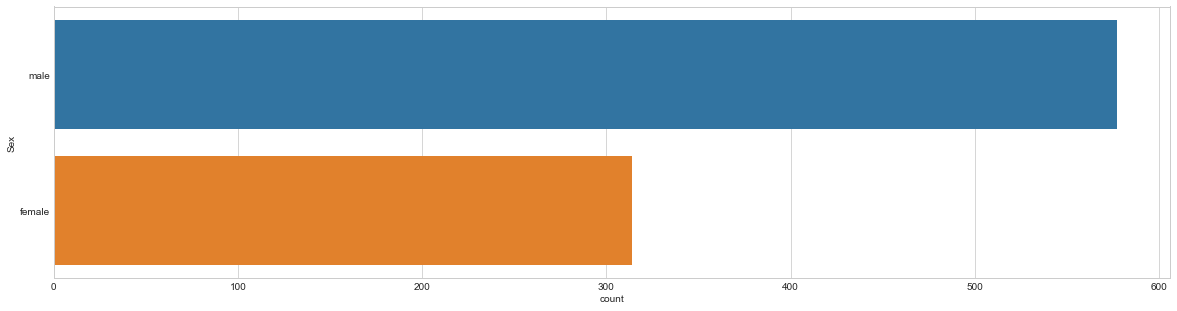

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(y='Sex',data=train)

In [20]:
#missing values?
train.Sex.isnull().sum()

0

In [21]:
df_bin['Sex']=train['Sex']
df_bin['Sex']=np.where(df_bin['Sex']=='female',1,0)
df_con['Sex']=train['Sex']
df_bin.head()

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


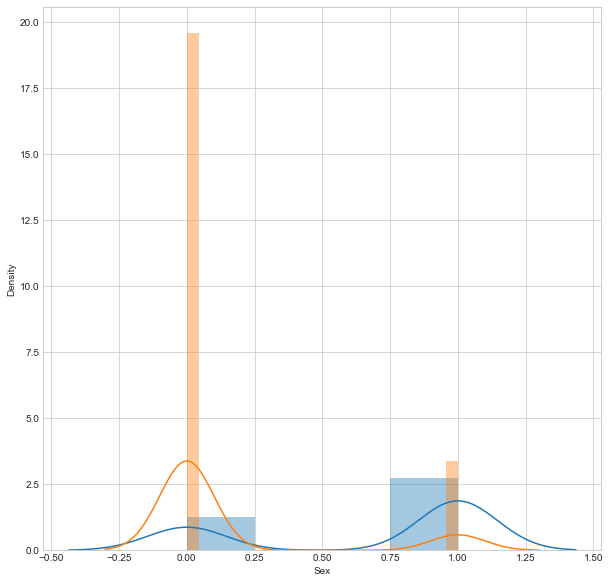

In [22]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

### Feature: Age
Description: The age of passengers

In [23]:
#Missing values??
train.Age.isnull().sum()

177

In [24]:
#Replace the missing with values mean of the column
train.Age=train.Age.fillna(train.Age.mean())

<AxesSubplot:xlabel='Age', ylabel='Density'>

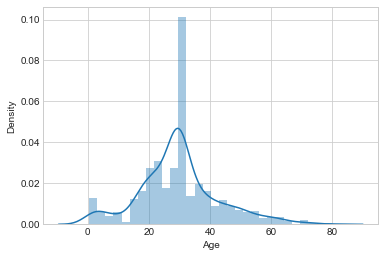

In [25]:
sns.distplot(train.Age)

In [26]:
df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
df_con['Age'] = train['Age'] # non-bucketed

#### Function to create count and distribution visualisations

In [27]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});


### Feature: SibSp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [28]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [29]:
train.SibSp.isnull().sum()

0

In [30]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

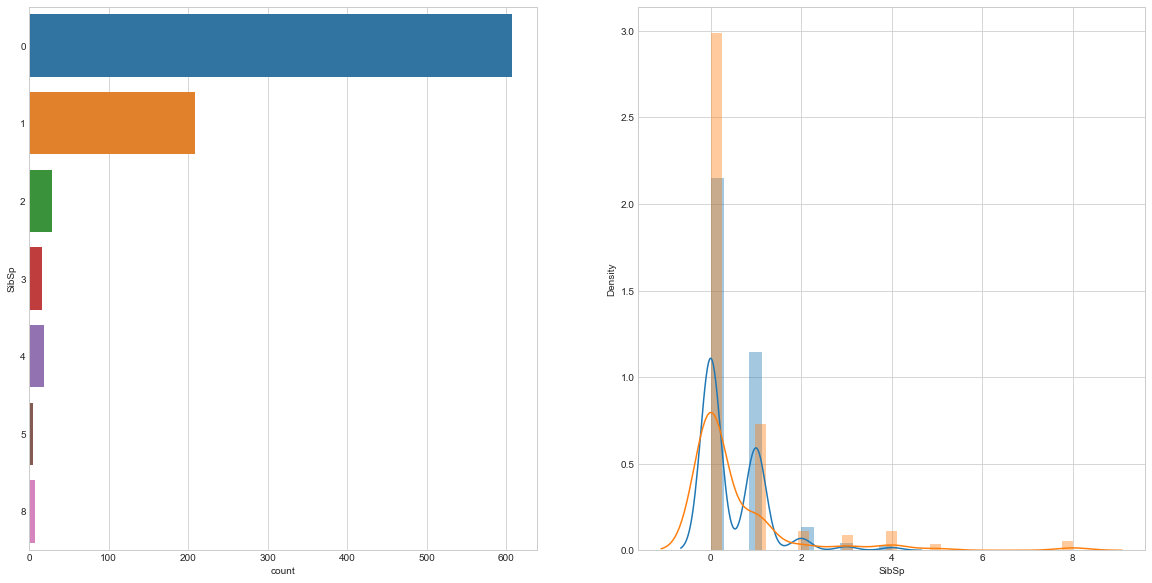

In [31]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [32]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [33]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [34]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

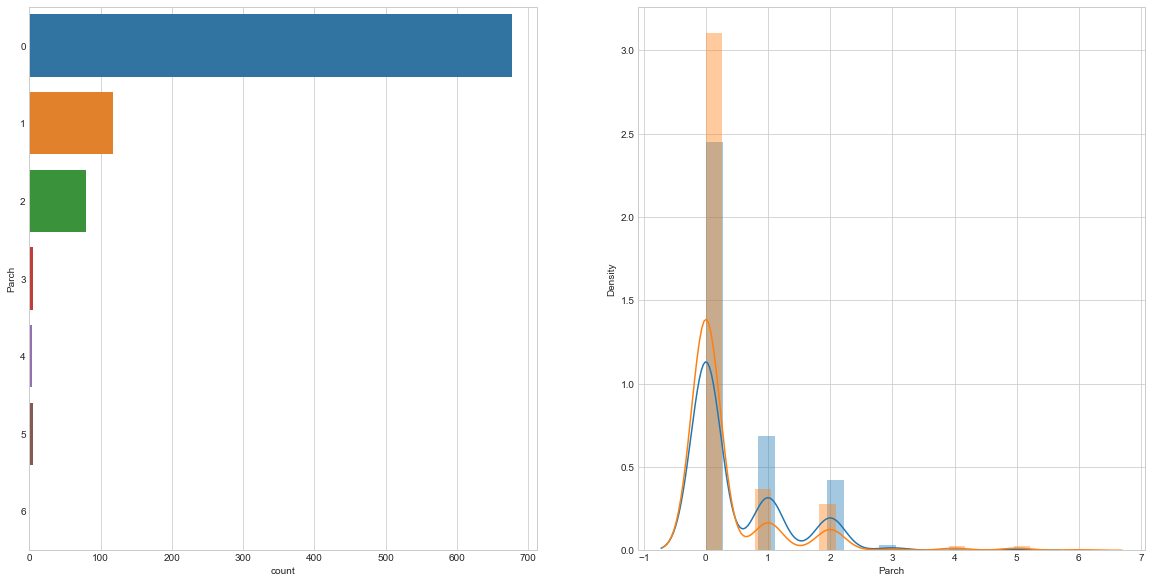

In [35]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

In [36]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,"(16.336, 24.294]",1,0
1,1,1,1,"(32.252, 40.21]",1,0
2,1,3,1,"(24.294, 32.252]",0,0
3,1,1,1,"(32.252, 40.21]",1,0
4,0,3,0,"(32.252, 40.21]",0,0


In [38]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [39]:
train.Ticket.isnull().sum()

0

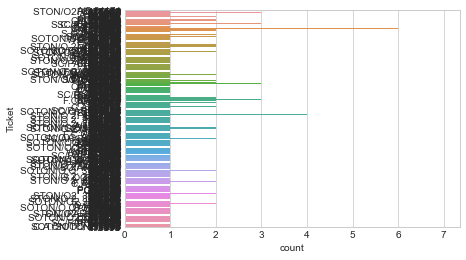

In [40]:
sns.countplot(y='Ticket', data=train);

In [41]:
train.Ticket.value_counts()

1601               7
347082             7
CA. 2343           7
347088             6
CA 2144            6
                  ..
SOTON/OQ 392086    1
C.A. 6212          1
A./5. 2152         1
230434             1
239856             1
Name: Ticket, Length: 681, dtype: int64

681 unique values is too many for now. So we won't use Ticket in our subset dataframes.

#### Feature Fare
Description: How much the ticket cost.

In [42]:
train.Fare.isnull().sum()

0

In [43]:
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

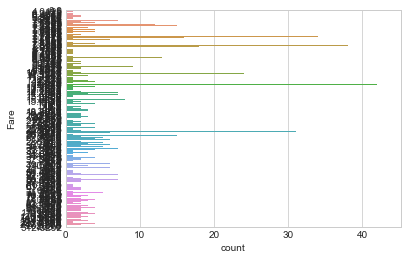

In [44]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [45]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [46]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised 

In [47]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

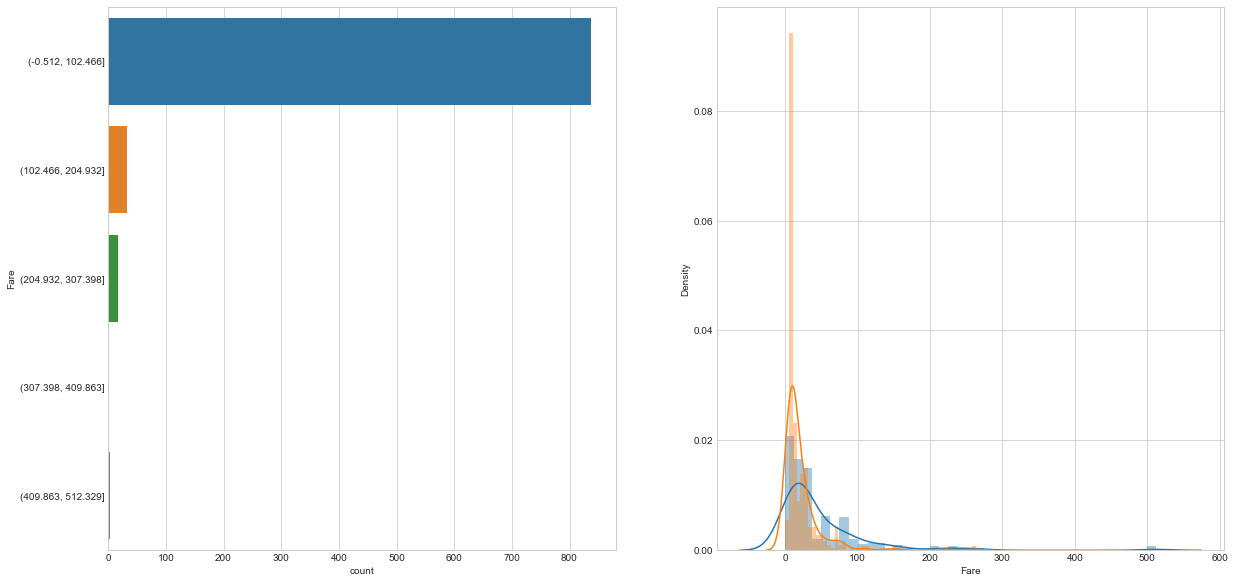

In [48]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

# Feature: Embarked

Description: The port where the passenger boarded the Titanic.
    
Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [49]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [50]:
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

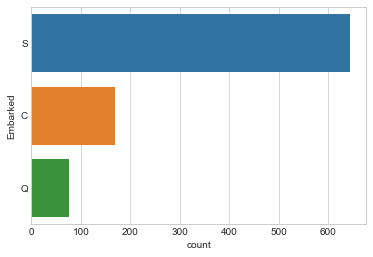

In [51]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [54]:
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


### Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (`df_bin`) with one-hot encoding and our continuous dataframe (`df_con`) with the label encoding function from `sklearn`.

In [55]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]",S
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",C
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]",S
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",S
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]",S


In [56]:
#One hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)
df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]",...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [57]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [58]:
df_embarked_one_hot=pd.get_dummies(df_con['Embarked'],prefix='embarked')
df_sex_one_hot=pd.get_dummies(df_con['Sex'],prefix='sex')
df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], prefix='pclass')

In [59]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [60]:
df_con_enc.head(20)

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.000000,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.000000,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.000000,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.000000,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,29.699118,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,54.000000,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,2.000000,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,27.000000,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,14.000000,1,0,30.0708,1,0,0,1,0,0,1,0


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [61]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [62]:
selected_df.head()

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [63]:
#Split dataframe into data and labels
X_train = selected_df.drop('Survived',axis=1)
y_train = selected_df.Survived

In [64]:
X_train.shape

(889, 12)

In [65]:
X_train.head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [75]:
y_train.shape

(889,)

### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [66]:
def fit_ml_algo(algo, X_train, y_train,cv):
    
    #One pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100,2)
    
    #cross-validation
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train, cv=cv, n_jobs=-1)
    
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv 


In [67]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.43
Accuracy CV 10-Fold: 79.87
Running Time: 0:00:05.896768


In [68]:
#K-Nearest Neighbors
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(),
                                                  X_train,
                                                  y_train,
                                                  10)
knn_time = (time.time()-start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 82.11
Accuracy CV 10-Fold: 71.09
Running Time: 0:00:00.311337


In [69]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 78.4
Running Time: 0:00:00.094785


In [70]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.97
Accuracy CV 10-Fold: 68.39
Running Time: 0:00:00.265725


In [71]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 78.18
Accuracy CV 10-Fold: 70.08
Running Time: 0:00:00.112018


In [72]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 98.2
Accuracy CV 10-Fold: 77.17
Running Time: 0:00:00.130164


In [73]:
model = GradientBoostingClassifier().fit(X_train, y_train)
acc = round(model.score(X_train, y_train) * 100,2)
    
#cross-validation
train_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=10, n_jobs=-1)
    
# Cross-validation accuracy metric
acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc)
print("Accuracy CV 10-Fold: %s" % acc_cv)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))


Accuracy: 89.2
Accuracy CV 10-Fold: 83.01
Running Time: 0:00:01.180460


## Model Results
Which model had the best cross-validation accuracy?

**Note:** We care most about cross-validation metrics because the metrics we get from `.fit()` can randomly score higher than usual.

### Regular accuracy scores

In [76]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              ],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc,
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,98.20
6,Gradient Boosting Trees,89.20
0,KNN,82.11
1,Logistic Regression,80.43
4,Linear SVC,78.97
2,Naive Bayes,78.52
3,Stochastic Gradient Decent,78.18


In [77]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'
             ],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
6,Gradient Boosting Trees,83.01
1,Logistic Regression,79.87
2,Naive Bayes,78.40
5,Decision Tree,77.17
0,KNN,71.09
3,Stochastic Gradient Decent,70.08
4,Linear SVC,68.39


We can see from the tables, the GradientBoostingTrees model had the best results. Getting just under 83% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the `.fit()` models as it does multiple passes over the data instead of one.

Because the GradientBoostingTrees model got the best results, we'll use it for the next steps.

## Feature Importance
Which features of the best model were most important for making predictions?

In [78]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
10,0.000249,pclass_2
2,0.002084,Parch
4,0.002544,embarked_C
5,0.002968,embarked_Q
6,0.016128,embarked_S
9,0.029536,pclass_1
1,0.057778,SibSp
11,0.120590,pclass_3
0,0.124152,Age
3,0.168121,Fare


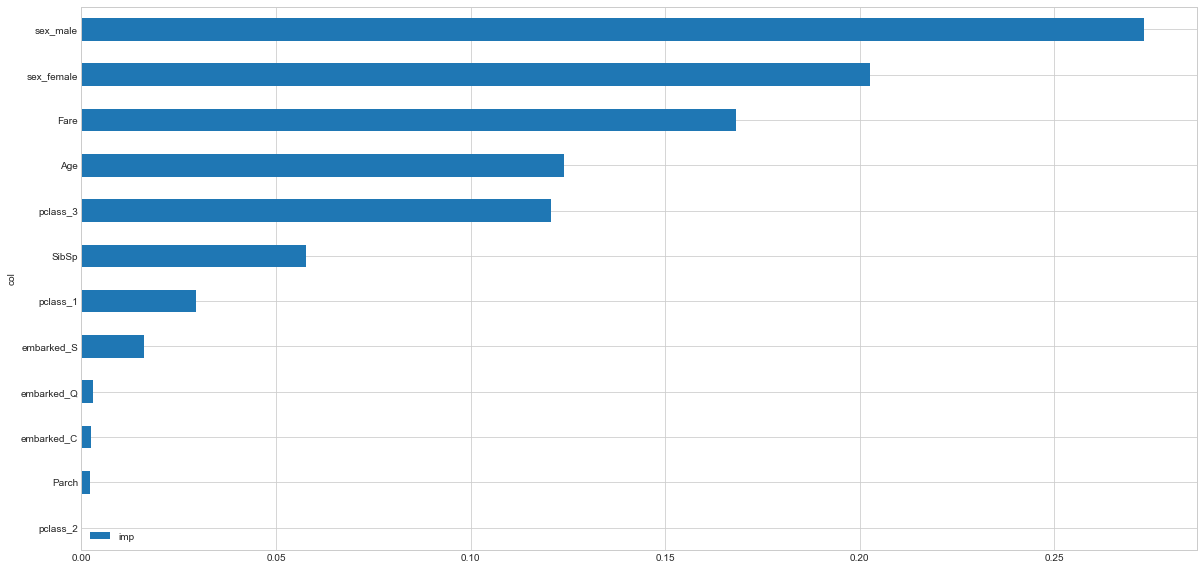

In [79]:
# Plot the feature importance scores
feature_importance(model, X_train)

## Classification report

In [80]:
gradient_booster=GradientBoostingClassifier().fit(X_train,y_train)
print(classification_report(y_train,gradient_booster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       549
           1       0.90      0.81      0.85       340

    accuracy                           0.89       889
   macro avg       0.89      0.88      0.88       889
weighted avg       0.89      0.89      0.89       889



## Submission

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the `test` dateframe, encode them and make a prediciton with our model.

In [81]:
X_train.head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [82]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [83]:
# One Hot Encode columns of test dataframe
test_embarked_one_hot = pd.get_dummies(test['Embarked'],prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'],prefix='sex')

test_pclass_one_hot = pd.get_dummies(test['Pclass'],prefix='pclass')

In [84]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_pclass_one_hot], axis=1)

In [85]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


In [86]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q',
       'embarked_S', 'sex_female', 'sex_male', 'pclass_1', 'pclass_2',
       'pclass_3'],
      dtype='object')

In [87]:
test[wanted_test_columns].head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,34.5,0,0,7.8292,0,1,0,0,1,0,0,1
1,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,22.0,1,1,12.2875,0,0,1,1,0,0,0,1


In [93]:
test[wanted_test_columns].isnull().sum()

Age           86
SibSp          0
Parch          0
Fare           1
embarked_C     0
embarked_Q     0
embarked_S     0
sex_female     0
sex_male       0
pclass_1       0
pclass_2       0
pclass_3       0
dtype: int64

In [94]:
test.Age=test.Age.fillna(train.Age.mean())

In [95]:
test.Fare=test.Fare.fillna(train.Fare.mean())

In [97]:
predictions = model.predict(test[wanted_test_columns])

In [98]:
predictions[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int64)

In [101]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [103]:
gender_submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [104]:
# Let's convert our submission dataframe 'Survived' column to ints
submission['Survived'] = submission['Survived'].astype(int)
print('Converted Survived column to integers.')

Converted Survived column to integers.


In [105]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [113]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [114]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
